### Implementing ReAct Agents With LangGraph

ReACT (Reasoning and Acting) Agents are AI systems that combine reasoning capabilities of LLMs with action execution, \
enabling them to iteratively think through problems, use tools, and act based on observations to achieve the user goals.

The ReAct agent:

1. Takes a user query as input
2. Reasons about the query and decides on an action
3. Executes the chosen action using available tools
4. Observes the result of the action
5. Repeats steps 2-4 until it can provide a final answer

**LangGraph models agent as graphs. You define the behavior of agents using three key components:**

State: Shared data structure that represents the current snapshot of your application. It can be any Python type, \
but is typically a TypedDict or Pydantic BaseModel, which is shared across all nodes.

Nodes: Encodes logic of your agents. They receive the current State as input, perform some computation or side-effect,
and return an updated State, e.g. LLM calls, tool calls, etc. 

Edges: Determine which Node to execute next based on the current State. They can be conditional branches or fixed transitions.

In [ ]:
!pip install langgraph langchain-google-genai geopy requests

In [2]:
import os
from dotenv import load_dotenv

In [7]:
load_dotenv()

#os.environ['API_KEY'] = os.getenv('GEMINI_API_KEY')
api_key = os.getenv('GEMINI_API_KEY')

In [4]:
from typing import Annotated,Sequence, TypedDict
 
from langchain_core.messages import BaseMessage 
from langgraph.graph.message import add_messages # helper function to add messages to the state
 
 
class AgentState(TypedDict):
    """The state of the agent."""
    messages: Annotated[Sequence[BaseMessage], add_messages]
    number_of_steps: int

In [5]:
from langchain_core.tools import tool
from geopy.geocoders import Nominatim
from pydantic import BaseModel, Field
import requests
 
geolocator = Nominatim(user_agent="weather-app") 
 
class SearchInput(BaseModel):
    location:str = Field(description="The city and state, e.g., San Francisco")
    date:str = Field(description="the forecasting date for when to get the weather format (yyyy-mm-dd)")
 
@tool("get_weather_forecast", args_schema=SearchInput, return_direct=True)
def get_weather_forecast(location: str, date: str):
    """Retrieves the weather using Open-Meteo API for a given location (city) and a date (yyyy-mm-dd). Returns a list dictionary with the time and temperature for each hour."""
    location = geolocator.geocode(location)
    if location:
        try:
            response = requests.get(f"https://api.open-meteo.com/v1/forecast?latitude={location.latitude}&longitude={location.longitude}&hourly=temperature_2m&start_date={date}&end_date={date}")
            data = response.json()
            return {time: temp for time, temp in zip(data["hourly"]["time"], data["hourly"]["temperature_2m"])}
        except Exception as e:
            return {"error": str(e)}
    else:
        return {"error": "Location not found"}
 
tools = [get_weather_forecast]

In [9]:
from langchain_google_genai import ChatGoogleGenerativeAI
  
# Create LLM class 
llm = ChatGoogleGenerativeAI(
    model= "gemini-2.5-flash", # replace with "gemini-2.0-flash"
    temperature=1.0,
    max_tokens=None,
    timeout=None,
    max_retries=2,
    google_api_key=api_key,
)
 
# Bind tools to the model
model = llm.bind_tools([get_weather_forecast])
 
# Test the model with tools
model.invoke("What is the weather in Chennai on 20th of July 2025?")

AIMessage(content='', additional_kwargs={'function_call': {'name': 'get_weather_forecast', 'arguments': '{"date": "2025-07-20", "location": "Chennai"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': []}, id='run--f5761955-88ee-45a9-99da-a5c0fd56dc3a-0', tool_calls=[{'name': 'get_weather_forecast', 'args': {'date': '2025-07-20', 'location': 'Chennai'}, 'id': 'e3601514-558a-4f01-91aa-d43ef9f240e4', 'type': 'tool_call'}], usage_metadata={'input_tokens': 132, 'output_tokens': 31, 'total_tokens': 274, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 111}})

In [10]:
import json
from langchain_core.messages import ToolMessage, SystemMessage
from langchain_core.runnables import RunnableConfig
 
tools_by_name = {tool.name: tool for tool in tools}
 
# this is similar to customizing the create_react_agent with 'prompt' parameter, but is more flexible
# system_prompt = SystemMessage(
#     "You are a helpful assistant that use tools to access and retrieve information from a weather API. Today is 2025-03-04. Help the user with their questions. Use the history to answer the question."
# )
 
# Define our tool node
def call_tool(state: AgentState):
    outputs = []
    # Iterate over the tool calls in the last message
    for tool_call in state["messages"][-1].tool_calls:
        # Get the tool by name
        tool_result = tools_by_name[tool_call["name"]].invoke(tool_call["args"])
        outputs.append(
            ToolMessage(
                content=tool_result,
                name=tool_call["name"],
                tool_call_id=tool_call["id"],
            )
        )
    return {"messages": outputs}
 
def call_model(
    state: AgentState,
    config: RunnableConfig,
):
    # Invoke the model with the system prompt and the messages
    response = model.invoke(state["messages"], config)
    # We return a list, because this will get added to the existing messages state using the add_messages reducer
    return {"messages": [response]}
 
 
# Define the conditional edge that determines whether to continue or not
def should_continue(state: AgentState):
    messages = state["messages"]
    # If the last message is not a tool call, then we finish
    if not messages[-1].tool_calls:
        return "end"
    # default to continue
    return "continue"

In [11]:
from langgraph.graph import StateGraph, END
 
# Define a new graph with our state
workflow = StateGraph(AgentState)
 
# 1. Add our nodes 
workflow.add_node("llm", call_model)
workflow.add_node("tools",  call_tool)
# 2. Set the entrypoint as `agent`, this is the first node called
workflow.set_entry_point("llm")
# 3. Add a conditional edge after the `llm` node is called.
workflow.add_conditional_edges(
    # Edge is used after the `llm` node is called.
    "llm",
    # The function that will determine which node is called next.
    should_continue,
    # Mapping for where to go next, keys are strings from the function return, and the values are other nodes.
    # END is a special node marking that the graph is finish.
    {
        # If `tools`, then we call the tool node.
        "continue": "tools",
        # Otherwise we finish.
        "end": END,
    },
)
# 4. Add a normal edge after `tools` is called, `llm` node is called next.
workflow.add_edge("tools", "llm")
 
# Now we can compile and visualize our graph
graph = workflow.compile()

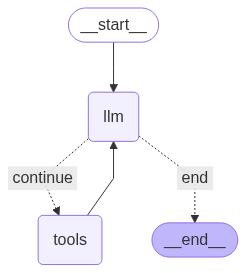

In [12]:
 
from IPython.display import Image, display
 
display(Image(graph.get_graph().draw_mermaid_png()))

In [14]:
# Create our initial message dictionary
inputs = {"messages": [("user", "How is the weather in Chennai on 20th of July 2025?")]}
 
# call our graph with streaming to see the steps
 
for state in graph.stream(inputs, stream_mode="values"):
    last_message = state["messages"][-1]
    last_message.pretty_print()

================================ Human Message =================================

How is the weather in Chennai on 20th of July 2025?
================================== Ai Message ==================================
Tool Calls:
  get_weather_forecast (6519abba-a3de-4494-8b67-1e09ce50faff)
 Call ID: 6519abba-a3de-4494-8b67-1e09ce50faff
  Args:
    date: 2025-07-20
    location: Chennai
================================= Tool Message =================================
Name: get_weather_forecast

{'2025-07-20T00:00': 26.4, '2025-07-20T01:00': 26.3, '2025-07-20T02:00': 26.6, '2025-07-20T03:00': 27.2, '2025-07-20T04:00': 27.9, '2025-07-20T05:00': 29.1, '2025-07-20T06:00': 30.2, '2025-07-20T07:00': 30.9, '2025-07-20T08:00': 31.7, '2025-07-20T09:00': 31.9, '2025-07-20T10:00': 31.8, '2025-07-20T11:00': 31.3, '2025-07-20T12:00': 30.2, '2025-07-20T13:00': 28.9, '2025-07-20T14:00': 28.5, '2025-07-20T15:00': 28.5, '2025-07-20T16:00': 28.1, '2025-07-20T17:00': 27.9, '2025-07-20T18:00': 27.7, '2025-07-